## Problem 2 - Flowers Dataset

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torch.nn import MaxPool2d
from torch.nn import AvgPool2d
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
use_cuda = torch.cuda.is_available()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
testlosses=[]

In [3]:
#Loading the dataset numpy files
data=np.load("flower_imgs.npy")
label=np.load("flower_labels.npy")
print(len(data),len(label))

4323 4323


In [4]:
#Finding mean and standard deviation of all images in the dataset
img_mean = np.mean(np.swapaxes(data/255.0,0,1).reshape(3, -1), 1)
img_std = np.std(np.swapaxes(data/255.0,0,1).reshape(3, -1), 1)

In [5]:
#Transformations on the dataset
#Normalise on the calculated mean and standard deviation
normalize = transforms.Normalize(mean=list(img_mean), std=list(img_std))
#Other transformations: Crop Image and horizontally flip
transform = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), normalize])

In [6]:
#Splitting the dataset into trainign and testing: The split is the default split of: 85% (training) - 15% (testing)
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 0.15)
print(np.array(x_train).shape, np.array(y_train).shape, np.array(x_test).shape, np.array(y_test).shape)

(3674, 32, 32, 3) (3674,) (649, 32, 32, 3) (649,)


In [8]:
#Loads the images using loader class
#Abstract clss representing a dataset
class ImgLoader(Dataset):
    def __init__(self, x, y,iscuda=False, transform=None):
        self.x = np.array(x)
        self.y = np.array(y)
        self.transform=transform
        self.cuda = iscuda

#supports indexing
    def __getitem__(self, index):
        x_val = self.x[index]
        x_val = torch.from_numpy(x_val).permute(2, 1, 0)
        y_val = torch.from_numpy(np.array([self.y[index]]))
        return x_val, y_val

#returns size of dataset
    def __len__(self):
        return len(self.x)

In [9]:
#Checks for whether cuda is available so as to run on GPU or not
use_cuda = torch.cuda.is_available()
#img_loadertrain has the training images; on which transformations have been performed
img_loadertrain = ImgLoader(x_train, y_train, use_cuda, transform=transform)
#Training data loaded into the Network having batch size = 100
trainloader = DataLoader(img_loadertrain, batch_size=100, shuffle=True, num_workers=4)

#img_loadertest has the testing images; on which transformations have been performed
img_loadertest = ImgLoader(x_test, y_test, use_cuda, transform=transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.ToTensor(),normalize]))
#Testing data loaded into the Network having batch size = 100
testloader = DataLoader(img_loadertest, batch_size=100, shuffle=True, num_workers=4)

In [48]:
#Network model 1 which stays stagnant after a point
# class ConvClassifier(nn.Module):
#     def __init__(self):
#         super(ConvClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
#         self.bn3 = nn.BatchNorm2d(128)

#         self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1)
#         self.bn4 = nn.BatchNorm2d(64)

#         self.conv5 = nn.Conv2d(64, 64, kernel_size=5, padding=1, stride=2)
#         self.bn5 = nn.BatchNorm2d(64)
#         self.fc1 = nn.Linear(64*15*15, 100)
#         self.fc2 = nn.Linear(100, 5)

        
#     def forward(self, x):
#         self.conv_l1 = self.conv1(x)
#         self.conv_l1 = self.bn1(self.conv_l1)
        
#         self.conv_l2 = F.relu(self.conv2(self.conv_l1))
#         self.conv_l2 = self.bn2(self.conv_l2)
        
#         self.conv_l3 = F.relu(self.conv3(self.conv_l2))
#         self.conv_l3 = self.bn3(self.conv_l3)

#         self.conv_l4 = F.relu(self.conv4(self.conv_l3))
#         self.conv_l4 = self.bn4(self.conv_l4)

#         self.conv_l5 = F.relu(self.conv5(self.conv_l4))
#         self.conv_l5 = self.bn5(self.conv_l5)

#         self.fc_l1 = self.conv_l5.view(-1, 64 * 15 * 15)
#         self.fc_l1 = F.relu(self.fc1(self.fc_l1))
#         self.fc_l2 = self.fc2(self.fc_l1) 
        
#         return F.log_softmax(self.fc_l2)  

In [49]:
#Network model 2
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 5)
       

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        out = F.softmax(out, dim=1)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [50]:
#Network model 3
# class ConvClassifier(nn.Module):
#     def __init__(self):
#         super(ConvClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1)
#         self.bn2 = nn.BatchNorm2d(64)
         
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
#         self.bn4 = nn.BatchNorm2d(128)

#         self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1)
#         self.bn5 = nn.BatchNorm2d(128)

#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
#         self.bn7 = nn.BatchNorm2d(256)

#         self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1)
#         self.bn8 = nn.BatchNorm2d(256)

#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    
#         self.conv10 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1)
#         self.bn10 = nn.BatchNorm2d(512)

#         self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
#         self.bn11 = nn.BatchNorm2d(512)

#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
    
#         self.conv13 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
#         self.bn13 = nn.BatchNorm2d(512)

#         self.conv14 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
#         self.bn14 = nn.BatchNorm2d(512)

#         self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
    
#         self.pool6 = nn.AvgPool2d(kernel_size=1, stride=1)

#         self.fc1 = nn.Linear(512, 5)
        
#     def forward(self, x):
#         self.conv_l1 = self.conv1(x)
#         self.conv_l1 = self.bn1(self.conv_l1)
        
#         self.conv_l2 = F.relu(self.conv2(self.conv_l1))
#         self.conv_l2 = self.bn2(self.conv_l2)
        
#         self.conv_l3 = self.pool1(self.conv_l2)
        
#         self.conv_l4 = F.relu(self.conv4(self.conv_l3))
#         self.conv_l4 = self.bn4(self.conv_l4)

#         self.conv_l5 = F.relu(self.conv5(self.conv_l4))
#         self.conv_l5 = self.bn5(self.conv_l5)
        
#         self.conv_l6 = self.pool2(self.conv_l5)

#         self.conv_l7 = F.relu(self.conv7(self.conv_l6))
#         self.conv_l7 = self.bn7(self.conv_l7)        
        
#         self.conv_l8 = F.relu(self.conv8(self.conv_l7))
#         self.conv_l8 = self.bn7(self.conv_l8)
        
#         self.conv_l9 = self.pool3(self.conv_l8)
        
#         self.conv_l10 = F.relu(self.conv10(self.conv_l9))
#         self.conv_l10 = self.bn10(self.conv_l10)        
        
#         self.conv_l11 = F.relu(self.conv11(self.conv_l10))
#         self.conv_l11 = self.bn11(self.conv_l11)
        
#         self.conv_l12 = self.pool4(self.conv_l11)
        
#         self.conv_l13 = F.relu(self.conv13(self.conv_l12))
#         self.conv_l13 = self.bn13(self.conv_l13)        
        
#         self.conv_l14 = F.relu(self.conv14(self.conv_l13))
#         self.conv_l14 = self.bn14(self.conv_l14)
        
#         self.conv_l15 = self.pool5(self.conv_l14)

#         self.conv_l16 = self.pool6(self.conv_l15)
        
#         self.fc_l1 = self.conv_l16.view(x.size(0), -1)
        
#         return F.softmax(self.fc_l1)

In [51]:
#Eval function called to calculate the accuracy of model
accuracy = 0
def eval(model, testloader):
    correct = 0
    for x,y in testloader:
        #x = torch.from_numpy(np.array([x])).permute(0, 3, 1, 2).type(torch.float32)
        x=x.type(torch.FloatTensor)
        y=y.type(torch.LongTensor)
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        out = model(Variable(x))
        #for multiclass classification, take class with maximum probability when got out of softmax output layer
        pred = out.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(y.view_as(pred)).sum().item()
    accuracy = correct * 1.0 / len(testloader)
    return accuracy

In [ ]:
def predi(model, x_train, y_train):
    i=0
    for (x,y) in zip(x_train,y_train):
        x = torch.from_numpy(np.array([x])).type(torch.float32)
        if use_cuda:
            x = x.cuda()
        out = model(Variable(x))
        #for binary classification, if predicted probability is more than 0.5, label as 1, else 0
        pred = out.max(1, keepdim=True)[1] # get the index of the max log-probability
        label = pred.eq(y.view_as(pred)).sum().item()
        if(y != label):
            print("index prediction actual")
            print(i+1, label, y)
        i = i+1

In [ ]:
pred(net, x_train, y_train)

In [52]:
#Evaltestloss function called to calculate the loss of testing data on the trained model
testlosses = []
def evaltestloss(model, testloader):
    net.train(False)
    for i, (x, y) in enumerate(testloader):
        x = x.type(torch.FloatTensor)
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        #reinitialise the optimiser gradient to 0
        optimizer.zero_grad()
        #input to the network is training data
        x = Variable(x)
        out = model(x)
        target = Variable(y.squeeze(1))
        testloss = criterion(out, target)
        testloss.backward()
        optimizer.step()
        testloss1 = testloss.data[0]
    return np.average(testloss1)

In [53]:
trainingloss = []
trainingloss1 = []
trlosses = []
tracc = []
teacc = []

In [54]:
epochs = 150
#criterion sets up the loss function; here Cross Entropy Loss is used
criterion = nn.CrossEntropyLoss()

#Object of the Network created

#net = ConvClassifier()
net = VGG('VGG13')

if use_cuda:
    net = net.cuda()

print("Print initial weights and biases")
print("Default initial weights: ")
print(net.conv1.weight)
print("Default initial biases: ")
print(net.conv1.bias)

#set up optimizer having parameters like epochs, batch size and learning rate
optimizer = optim.SGD(params=net.parameters(), lr=0.03, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#Train the network
for epoch in range(epochs):
    net.train(True)
    for i, (x, y) in enumerate(trainloader):
        #x = x.to(device, dtype=torch.float32)
        x=x.type(torch.FloatTensor)
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        
        #reinitialise the optimiser gradient to 0
        optimizer.zero_grad()
        
        #input to the network is training data
        inputs = Variable(x)
        #output of the network is trained inputs; net() calls the feedborward network
        output = net(inputs)
        #targets is the training labels
        targets = Variable(y.squeeze(1))
        
        #training loss calculated using criterion which is the Cross Entropy loss in this case
        trloss = criterion(output, targets)
        #Backward propoagation occurs
        trloss.backward()
        #Optimizer used to smoothen the learning and reducing the loss
        optimizer.step()
        
        #getting the training loss
       ### trlosses.append(trloss.item())
        trloss1=trloss.data[0]
        trlosses.append(trloss1)

    trainingloss.append(np.average(trloss1))
    trainacc = eval(net, trainloader)
    tracc.append(trainacc)
    testacc = eval(net, testloader)
    teacc.append(testacc)
    testloss = evaltestloss(net, testloader)
    testlosses.append(testloss)
    print('Train Epoch: {} Training Loss: {} Training Acc: {} Testing Loss: {} Testing Acc: {} '.format(epoch, np.average(trlosses), trainacc, testloss, testacc))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 0 Training Loss: 1.3969646692276 Training Acc: 55.4054054054054 Testing Loss: 1.7266912460327148 Testing Acc: 49.42857142857143 
Train Epoch: 1 Training Loss: 1.3776382207870483 Training Acc: 61.648648648648646 Testing Loss: 1.529322624206543 Testing Acc: 56.285714285714285 
Train Epoch: 2 Training Loss: 1.3817651271820068 Training Acc: 52.67567567567568 Testing Loss: 1.557242751121521 Testing Acc: 51.0 
Train Epoch: 3 Training Loss: 1.3687045574188232 Training Acc: 58.67567567567568 Testing Loss: 1.639460563659668 Testing Acc: 54.857142857142854 
Train Epoch: 4 Training Loss: 1.3547037839889526 Training Acc: 63.945945945945944 Testing Loss: 1.5130494832992554 Testing Acc: 59.57142857142857 
Train Epoch: 5 Training Loss: 1.341249704360962 Training Acc: 64.5945945945946 Testing Loss: 1.3404048681259155 Testing Acc: 57.57142857142857 
Train Epoch: 6 Training Loss: 1.3302066326141357 Training Acc: 65.29729729729729 Testing Loss: 1.3306587934494019 Testing Acc: 60.857142857142

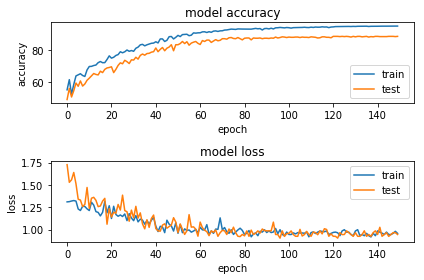

In [55]:
#Plotting the metrics
fig = plt.figure()
#printing training accuracy and testing accuracy
plt.subplot(2,1,1)
plt.plot(tracc)
plt.plot(teacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
#printing training loss and test loss
plt.subplot(2,1,2)
plt.plot(trainingloss)
plt.plot(testlosses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

#### WRITE UP


## 1. Training and testing accuracy vs epoch plots
We see the following training and testing accuracy vs epoch plots:
<br>Model 1 - VGG13
<br>A complex VGG13 model with ReLU activations and last fully connected layer having softmax activation was used. Cross-entropy loss with SGD optimizer gives the best result. The training and testing accuracy achieved is 94.2616% and 88.285% while, train and test loss is 1.032 and 0.945. This was got after 150 epochs with batch size of 100 and learning rate of 0.03 and momentum of 0.9. Plot for the same is shown below:
<br>Accuracy Plot and Loss Plot
<br><img src="best.png">
<br>
<br>Model 2
<br>The same model and learning rate but with no memomentum gave a varied loss with remained almost the same; 5.72 and 5.52 for train and test respectively, but accuracy curve was seen from 5.6% to 72% in training data and 5.90% to 66.71% in testing data. This is shown by the plot below:
<br>Accuracy Plot and Loss Plot
<br><img src="middle.png">

<br>Model 3
<br>The shallower model, with no momentum, learning rate of 0.03 for 10 epochs only, gives, training and testing accuracy of 47.37% and 48.47% and training and testing loss of 0.13208849728107452 and 0.003028332721441984. Also, the log_softmax activation was used, whhich gives a smootehr plot but becomes stagnant very soon. The plot for the same is shown below:
<br>Accuracy Plot and Loss Plot
<br><img src="shallow.png">



## 2. Representative of the weight and biases
Default initial weights: 

[[[[ 0.1074,  0.0619, -0.0035],
   [-0.0505, -0.0592, -0.1107],
   [-0.0418, -0.0867, -0.1023]], 
          
   ...,

   [[-0.1450, -0.0938,  0.1416],
   [-0.1406,  0.0216,  0.0858],
   [-0.0718, -0.0470,  0.0697]]]]
   
Default initial biases:

[ 0.1442,  0.1304, -0.1518, ....., 0.0081, -0.0288, -0.1886]
<br>The initialization of the weights happens as follows: Weights are initialised within the range [-stdv, stdv] where, stdv = 1. / math.sqrt(self.weight.size(1)) and if the bias is not None, then it is initialised within the same range. 
<br>It is beneficial to use small value for bias and hence, bias = True is included, but its more commonly used to have 0 biases.


## 3. What is used and why
4.1 Initial Shape
<br>The Flower dataset consists of 4323 records having images of the size (3 * 32 * 32).
<br>Preprocessing included normalising the images by the mean and deviation so as to centralise it. Training images were also flipped horizontally, at the same time cropped to get zoomed version.
<br>Then, splitting of training data and test data is done. This splitting is done as 85%-15% for training data and testing data respectively. 

<br>4.2 Transforming or preprocessing the data
<br>A normalisation of mean and standard deviation of all the images is found in img_mean and img_std to centralise the data and make it less scarttered. This avoids very large differences in gradients and hence learnt weights which would cause deviation.

## 4. About network's shape and layer choices, loss function and activation function
### 4.1 Network's shape
The data is very complex and it requires alot of preprocessing and hence has many parameters. The network consists of 13 convolutional layers, having ReLU applied to them and batch normalization applied after every layer and max-pooling layer applied every 2 layers. Lastly, there is a Average pooling layer and then softmax classification layer.
<br>The shape of the input is (3674, 32, 32, 3) that is 3674 images of (3*32*32) dimensions.
<br>This performs the classification into 5 classes of flower species.

<br><br>Another, shallower CNN is also modeled having 5 convolutional neural networks with ReLU in between and log_softmax in the end for classification.

### 4.2 Layer Choice
<br><br>4.2.1 CNN
<br>This layer takes each images features and learns from them to change the weights and biases to get a 5 class classification of flowers.
<br><br>4.2.2 Fully connected layers
<br>This layer takes is used to take all the features and reduce it to lower dimensions.
<br><br>4.2.2 SGD Optimizer
<br>SGD optimizer to gives the results as we have alot of features and batches are taken into consideration.
<br><br>4.2.3 Adam Optimizer
<br>This is the optimization algorithm used to handle sparse gradients if they occur during training.
<br><br>4.2.4 Learning Rate
<br>Slower learning rate gives smoother increase in accuracy over faster learning rate as can be seen in the plot.
<br><br>4.2.5 Momentum
<br>Momentum is the factor between 0 and 1 that increases the step size to come out of local minimas and reach the global minima. A momentum factor of 0.9 is used here, so as to not stagnate the gradient to lessen the speed and inturn make it faster.
<br><br>4.2.6 Batch Normalisation
<br>Batch normalisation is performed after each and every CNN layer to normalise the weights and biases so that extremities in ranges is not reached and gradients are within some defined range to prevent divergence of learning.

### 4.3 Loss Function:
Cross Entropy Loss is used as the loss function as, multi-class classification has to be done. This calculates loss error between real values and predicted values.

### 4.4 Activation Function:
4.4.1 ReLU
<br>Used as activation function in the CNN layer as it is the most widely used because it reduces training time and prevents problem of vanishing gradients. This can be understood by its formula; f(x)=max(0, x) where x is input. So, it sets all negative values in input matrix to 0 while keeping other values as is.
<br><br>4.4.2 Softmax Activation
<br>Softmax converts the output into probability distribution over 5 classes. The addition of probabilities of the 5 classes equals to 1. The class having the largest output softmax probability is the class the image belongs to.

### 4.5 Splitting Dataset
The dataset is supposed to be technically divided into a 67%-33%; training and testing data because it is widely performed and most efficient. But, here, the minimum split is used, as 85%-15%.


### 4.6 Datapoints that failed
From the results shown above following are few samples that are incorrectly classified:

<br>index prediction actual
<br>36 1 2
<br>362 2 3
<br>645 1 0
<br>3241 0 1
